In [8]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
rcParams['figure.figsize'] = 10, 5
rcParams['figure.max_open_warning'] = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
class Caller(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.cooldown = 0
        
    def on_train_begin(self, logs={}):
        scale_filter_output()
        
    def on_batch_end(self, batch, logs={}):
        self.cooldown += 1
        if self.cooldown > 64:
            scale_filter_output()
            self.cooldown = 0
            print('JO')
        
#         self.model.layers[0]
#         self.losses.append(logs.get('loss'))

In [17]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, use_bias=False))
model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', use_bias=False))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[Caller()]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('mnist_nobias_last')


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 158s - loss: 0.6288 - acc: 0.8683 - val_loss: 0.1496 - val_acc: 0.9632
Epoch 2/6
60000/60000 [==============================] - 183s - loss: 0.1596 - acc: 0.9565 - val_loss: 0.0898 - val_acc: 0.9721
Epoch 3/6
60000/60000 [==============================] - 170s - loss: 0.0956 - acc: 0.9718 - val_loss: 0.0594 - val_acc: 0.9816
Epoch 4/6
60000/60000 [==============================] - 189s - loss: 0.0660 - acc: 0.9804 - val_loss: 0.0543 - val_acc: 0.9825
Epoch 5/6
60000/60000 [==============================] - 219s - loss: 0.0549 - acc: 0.9833 - val_loss: 0.0493 - val_acc: 0.9838
Epoch 6/6
60000/60000 [==============================] - 221s - loss: 0.0435 - acc: 0.9863 - val_loss: 0.0473 - val_acc: 0.9859
Test loss: 0.0472685110254
Test accuracy: 0.9859


OSError: Unable to create file (Unable to truncate a file which is already open)

In [13]:
def quantize(x, bits=8):
    # actual bits is +1 because of sign
    step = 2**(-bits)
    steps = np.round(x / step)
    return steps * step
    

def scale_filter_output(bits=8):
    c0 = model.layers[0].get_weights()[0]
    c0s = c0.reshape(32, 3, 3)
    
    def quant_filter(f):
        for i, row in enumerate(f):
            for j, item in enumerate(row):
                f[i][j] = quantize(item)

    s = []
    for i, x in enumerate(c0s):
        m = np.abs(x).max()
        s = np.abs(np.sum(x))
        mm = max(m, s) * (1 / (1 - 2**(-bits)))
        c0s[i] = x / mm
        quant_filter(c0s[i])
        
    

    c0ss = c0s.reshape(c0.shape)
    model.layers[0].set_weights([c0ss])
    
    c = model.layers[1].get_weights()[0]
    cs = c.reshape(64, 32, 3, 3)

    s = []
    for i, xx in enumerate(cs):
        for j, x in enumerate(xx):
            m = np.abs(x).max()
            s = np.abs(np.sum(x))
            mm = max(m, s) * (1 / (1 - 2**(-bits)))
            cs[i][j] = x / mm
            quant_filter(cs[i][j])
    
    css = cs.reshape(c.shape)
    model.layers[1].set_weights([css])
    

In [14]:
quantize(0.98)

0.98046875

In [16]:
model.load_weights('mnist_nobias_last')
# scale_coefs()
scale_filter_output()
# scale_coefs()

ValueError: You are trying to load a weight file containing 4 layers into a model with 3 layers.

In [245]:
scale_filter_output()
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.212235253066
Test accuracy: 0.9553


In [217]:
print(model.layers[-1].get_weights()[0].min())

-0.247223


288


<IPython.core.display.Javascript object>


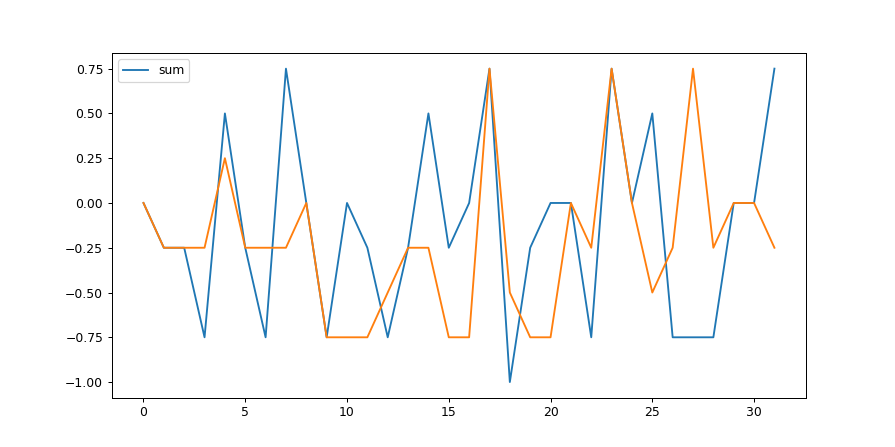

In [246]:
import numpy as np
c0 = model.layers[0].get_weights()[0]
c0s = c0.reshape(32, 3, 3)
print(c0s.size)

# print(c0s)
s = []
m = []
for x in c0s:
    s.append(np.sum(x))
    if x.max() > np.abs(x.min()):
        m.append(x.max())
    else:
        m.append(x.min())
        
#     m.append(np.max(np.max(x)))
#     print(np.sum(x))

plt.plot(s, label='sum')
plt.plot(m)
plt.legend()
plt.show()


(3, 3, 32, 64)
0.75 -0.75
18432


<IPython.core.display.Javascript object>


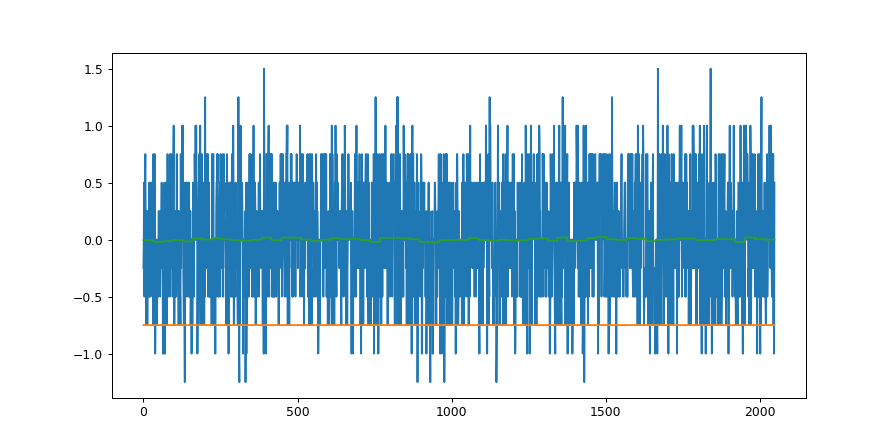

In [247]:
c = model.layers[1].get_weights()[0]
print(c.shape)
cs = c.reshape(64, 32, 3, 3)
print(cs.max(), cs.min())
print(cs.size)

s = []
m = []
a = []
for x in cs:
    for xx in x:
        s.append(np.sum(xx))
        if x.max() > np.abs(x.min()):
            m.append(x.max())
        else:
            m.append(x.min())
        a.append(np.mean(x))
#         print(np.sum(xx))
        
plt.plot(s)
plt.plot(m)
plt.plot(a)
plt.show()


In [231]:
c = model.layers[-1].get_weights()[0]
c.size

1280